# Hierarchical Clustering Asset Allocation with MlFinLab

## Abstract
The following notebook will explore MlFinLab's implementation of Thomas Raffinot's Hierarchical Equal Risk Contribution portfolio optimization technique. Users will be taken through how they can construct an optimal portfolio and the different risk metrics and linkage algorithms supported. Additionally, users will be able to see how they can create custom use cases with this library.

## Introduction
This tutorial will show users how to optimize a portfolio using the __[Hierarchical Equal Risk Contribution](https://ssrn.com/abstract=3237540)__ (HERC) optimization technique provided through the MlFinLab library. The HERC technique was developed by Thomas Raffinot in 2018, which built off his original __[Hierarchical Clustering Asset Allocation](https://ssrn.com/abstract=2840729)__ (HCAA) technique from 2017. The official documentation for this tutorial can be found __[here](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 


From Raffinot's 2018 paper on the HERC optimization technique, the following steps for implementation of the HCAA and HERC techniques were shown. 

Raffinot described the HCAA implementation in four steps:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Capital is allocated across clusters
4. Capital is allocated within clusters

HERC is built off this original implementation, combining the machine learning approach of the HCAA technique with the Top-Down recursive bisection approach from the __[Hierarchical Risk Parity](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__ algorithm. The HERC algorithm aims to diversify capital and risk allocations throughout the portfolio.

The steps for the HERC implementation are computed as:
1. Hierarchical clustering
2. Selecting the optimal number of clusters
3. Top-Down recursive bisection
4. Implement Naive Risk Parity within clusters to allocate weights to each asset

### Supported Allocation Metrics

The HERC implementation provided through MlFinLab currently supports the following metrics for calculating weight allocations:
1. 'minimum_variance': The variance of the clusters is used as a risk metric
2. 'minimum_standard_deviation': The standard deviation of the clusters is used as a risk metric
3. 'sharpe_ratio': The Sharpe ratio of the clusters is used as a risk metric
4. 'equal_weighting': All clusters are weighted equally with respect to the risk
5. 'expected_shortfall': The expected shortfall of the clusters is used as a risk metric
6. 'conditional_drawdown_risk': The conditional drawdown at risk of the clusters is used as a risk metric

### Supported Linkage Methods

Additionally, MlFinLab allows users to customize the type of linkage algorithm for the use of clustering. The current supported linkage methods are:
1. Single Linkage - the distance between two clusters is the minimum distance between any two points in the clusters
2. Complete Linkage - the distance between two clusters is the maximum of the distance between any two points in the clusters
3. Average Linkage - the distance between two clusters is the average of the distance between any two points in the clusters
4. Ward Linkage - the distance between two clusters is the increase of the squared error from when two clusters are merged

**The default linkage method in MlFinLab is set as the Ward Linkage method.** To learn more about the different types of linkage methods, please refer to Raffinot's paper on the __[HCAA method](https://ssrn.com/abstract=2840729)__ or to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 

In [121]:
# Importing our required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mlfinlab.portfolio_optimization.hcaa import HierarchicalClusteringAssetAllocation

## The Data

In this tutorial, we will be working with the historical closing prices for 17 assets from 2010-2018. 

In [93]:
# preparing our data
raw_prices = pd.read_csv('assetalloc.csv', sep=';', parse_dates=True, index_col='Dates')
raw_prices = raw_prices.iloc[::-1]
x = raw_prices.index.get_loc('2010-01-01')
stock_prices = raw_prices.iloc[0:x[0], :]
stock_prices = stock_prices.sort_values(by="Dates").iloc[::-1]

stock_prices.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
2018-12-07,7651.33,3445.493,2798.29,1247.32,89.925,149.023,211.724,305.707,122.683,143.723,142.810,164.048,1690.28,257.795,5883.11,1070.241,436.10
2018-12-06,7703.81,3475.583,2786.85,1298.94,90.144,148.007,206.644,291.137,122.827,143.253,141.320,159.198,1682.30,262.281,6015.48,1140.644,452.01
2018-12-04,7258.34,3443.974,2663.99,1338.49,90.664,148.271,208.326,300.541,123.242,144.601,143.474,162.529,1557.33,263.595,5720.33,1176.882,440.63
2018-12-03,7214.76,3429.477,2783.02,1318.84,91.016,147.869,206.227,293.093,123.475,144.887,143.070,159.820,1601.06,266.864,5806.57,1222.200,445.74
2018-12-02,7177.06,3368.252,2656.00,1324.74,91.233,147.650,204.379,290.687,123.892,145.461,143.427,160.242,1490.98,260.445,5672.83,1153.373,439.25


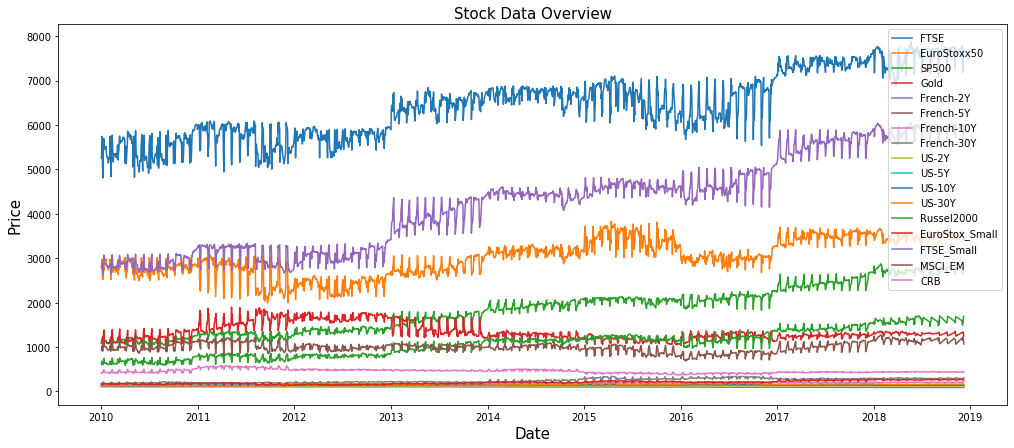

In [123]:
# Taking a quick look at our data
plt.figure(figsize=(17,7))
plt.plot(stock_prices)
plt.ylabel('Price', size=15)
plt.xlabel('Date', size=15)
plt.title('Stock Data Overview', size=15)
plt.legend(stock_prices.columns)
plt.show()

## Equal Weighting Portfolio
In the Equal Weighting portfolio, all the clusters are weighted equally in terms of risk to construct our optimal portfolio. The following image shows how asset allocation works with a small example, and highlights how important choosing the optimal number of clusters is in our algorithm.

<img src='ex_dendo2.jpg' style="width:400px;height:400px"/>



In this example, we will also be showing the different effects of using the four different linkage algorithms. We will first be using the Single Linkage method, then the Complete Linkage method, followed by the Average Linkage method, and finally the Ward Linkage method. Keep in mind that the default linkage algorithm is set to the Ward Linkage algorithm.

Note that the allocate method for the HierarchicalClusteringAssetAllocation() object requires three parameters to run: 
1. asset_names (a list of strings containing the asset names)
2. asset_prices (a dataframe of historical asset prices - daily close)
3. allocation_metric (the type of solution/algorithm to use to calculate the weights)

Users can also specify: 
1. The type of linkage algorithm (shown below) 
2. The confidence level used for calculating expected shortfall and conditional drawdown at risk 
3. The optimal number of clusters for clustering
4. How to resample the prices

For simplicity, we will only be working with the three required parameters and also specifying our linkage algorithm of choice. For more detailed notes on this implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__. 

In [95]:
# HCAA implementation with equal_weighting solution - Single Linkage
hcaaEW_single = HierarchicalClusteringAssetAllocation()
hcaaEW_single.allocate(asset_names=stock_prices.columns,
                       asset_prices=stock_prices,
                       allocation_metric='equal_weighting',
                       linkage='single')

print("Equal Weighting Portfolio Weights - Single Linkage \n", hcaaMV_single.weights)

Equal Weighting Portfolio Weights - Single Linkage 
       US-2Y    US-30Y    US-5Y   US-10Y  French-2Y  French-5Y  French-10Y  \
0  0.000004  0.000002  0.00012  0.02114   0.573209   0.029291    0.006433   

   French-30Y      Gold       CRB     SP500  Russel2000   MSCI_EM  FTSE_Small  \
0     0.00126  0.351273  0.008672  0.002211    0.000463  0.000067    0.000003   

       FTSE  EuroStoxx50  EuroStox_Small  
0  0.000024     0.000048        0.005779  


In [96]:
# HCAA implementation with equal_weighting solution - Complete Linkage
hcaaEW_complete = HierarchicalClusteringAssetAllocation()
hcaaEW_complete.allocate(asset_names=stock_prices.columns,
                         asset_prices=stock_prices,
                         allocation_metric='equal_weighting',
                         linkage='complete')

print("Equal Weighting Portfolio Weights - Complete Linkage \n", hcaaMV_complete.weights)

Equal Weighting Portfolio Weights - Complete Linkage 
         CRB     SP500  Russel2000   MSCI_EM  FTSE_Small     FTSE  EuroStoxx50  \
0  0.004301  0.002329    0.008697  0.118092    0.125032  0.01292      0.00246   

   EuroStox_Small      Gold     US-2Y    US-30Y     US-5Y    US-10Y  \
0        0.000482  0.308598  0.007619  0.001942  0.000407  0.004824   

   French-10Y  French-30Y  French-2Y  French-5Y  
0    0.003054    0.010764    0.00399   0.384491  


In [97]:
# HCAA implementation with equal_weighting solution - Average Linkage
hcaaEW_average = HierarchicalClusteringAssetAllocation()
hcaaEW_average.allocate(asset_names=stock_prices.columns,
                        asset_prices=stock_prices,
                        allocation_metric='equal_weighting',
                        linkage='average')

print("Equal Weighting Portfolio Weights - Average Linkage \n", hcaaMV_average.weights)

Equal Weighting Portfolio Weights - Average Linkage 
         CRB     SP500  Russel2000   MSCI_EM  FTSE_Small      FTSE  \
0  0.000912  0.000494    0.006632  0.078465    0.367943  0.018802   

   EuroStoxx50  EuroStox_Small      Gold     US-2Y    US-30Y     US-5Y  \
0     0.004129        0.000809  0.225482  0.005567  0.001419  0.000297   

     US-10Y  French-2Y  French-5Y  French-10Y  French-30Y  
0  0.003679   0.000648   0.002282    0.002578    0.279863  


In [98]:
# HCAA implementation with equal_weighting solution - Ward Linkage
hcaaEW_ward = HierarchicalClusteringAssetAllocation()
hcaaEW_ward.allocate(asset_names=stock_prices.columns,
                     asset_prices=stock_prices,
                     allocation_metric='equal_weighting',
                     linkage='ward')

print("Equal Weighting Portfolio Weights - Ward Linkage \n", hcaaMV_ward.weights)

Equal Weighting Portfolio Weights - Ward Linkage 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.003019  0.001635  0.006105    0.004829  0.017371     0.001795   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0        0.000342    0.000067  0.857751  0.045801  0.011677  0.002447   

     US-10Y  French-10Y  French-30Y  French-2Y  French-5Y  
0  0.003386    0.002144    0.007556   0.002801   0.031274  


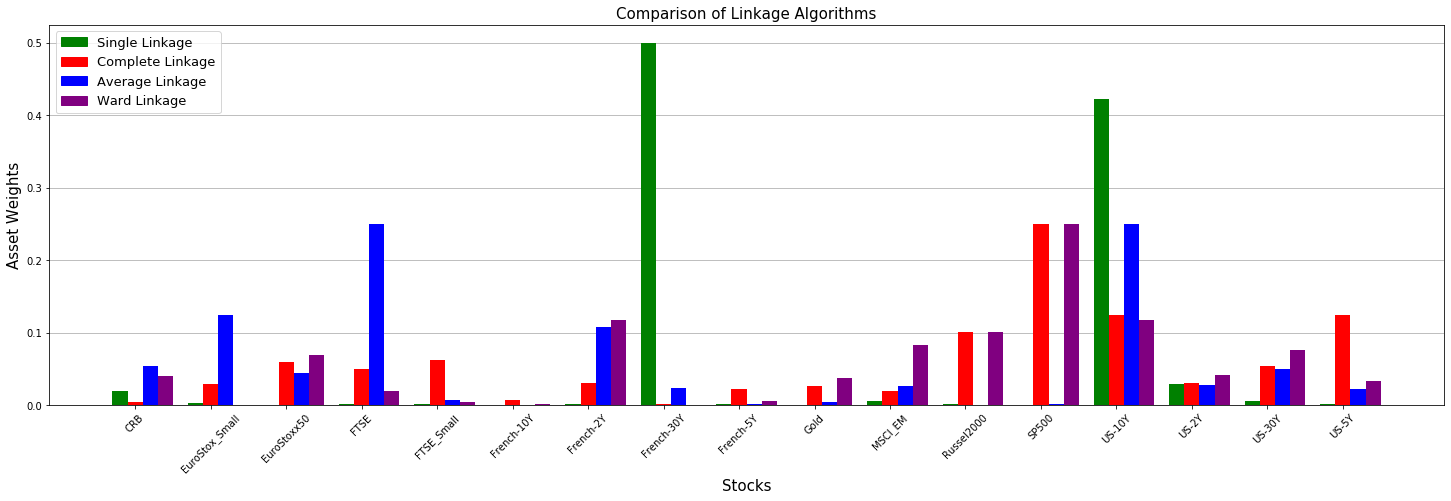

In [125]:
# Comparing our four Linkage algorithms
average = hcaaEW_average.weights[sorted(hcaaEW_average.weights)]
average = average.values.tolist()
average = [item for sublist in average for item in sublist]

complete = hcaaEW_complete.weights[sorted(hcaaEW_complete.weights)]
complete = complete.values.tolist()
complete = [item for sublist in complete for item in sublist]

single = hcaaEW_single.weights[sorted(hcaaEW_single.weights)]
single = single.values.tolist()
single = [item for sublist in single for item in sublist]

ward = hcaaEW_ward.weights[sorted(hcaaEW_ward.weights)]
ward = ward.values.tolist()
ward = [item for sublist in ward for item in sublist]

x = np.arange(len(average))
bar_width = 0.2

plt.figure(figsize=(25,7))
plt.bar(x, single, color='green', width=bar_width, zorder=2)
plt.bar(x + bar_width, complete, color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, average, color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, ward, color='purple', width=bar_width, zorder=2)

plt.xticks(x + bar_width, sorted(hcaaMV_average.weights), rotation=45, size=10)
plt.title('Comparison of Linkage Algorithms', size=15)
plt.xlabel('Stocks', size=15)
plt.ylabel('Asset Weights', size=15)

green_patch = mpatches.Patch(color='green', label='Single Linkage')
red_patch = mpatches.Patch(color='red', label='Complete Linkage')
blue_patch = mpatches.Patch(color='blue', label='Average Linkage')
purple_patch=mpatches.Patch(color='purple', label='Ward Linkage')
plt.legend(handles=[green_patch, red_patch, blue_patch, purple_patch], loc='upper left', prop={'size': 13})

plt.grid(axis='y')

plt.show()

Through this implementation, we can see how the four different linkage algorithms affect our optimal portfolio creation.

## Minimum Standard Deviation Portfolio
The Minimum Standard Deviation portfolio uses the standard deviation of the clusters as a risk metric to solve for the optimal portfolio. 

In [102]:
# HCAA implementation with minimum_standard_deviation solution
hcaaMSD = HierarchicalClusteringAssetAllocation()
hcaaMSD.allocate(asset_names=stock_prices.columns,
                 asset_prices=stock_prices,
                 allocation_metric='minimum_standard_deviation')

print("Minimum Standard Deviation Portfolio Weights \n", hcaaMSD.weights)

Minimum Standard Deviation Portfolio Weights 
    MSCI_EM       CRB  EuroStoxx50  EuroStox_Small     SP500  Russel2000  \
0  0.06652  0.032044     0.055048        0.000268  0.450342    0.025135   

       FTSE  FTSE_Small  French-2Y  French-5Y  French-10Y  French-30Y  \
0  0.004932    0.001167    0.11224   0.005313    0.001539    0.000362   

       Gold     US-2Y    US-30Y     US-5Y    US-10Y  
0  0.029871  0.033501  0.060418  0.027223  0.094076  


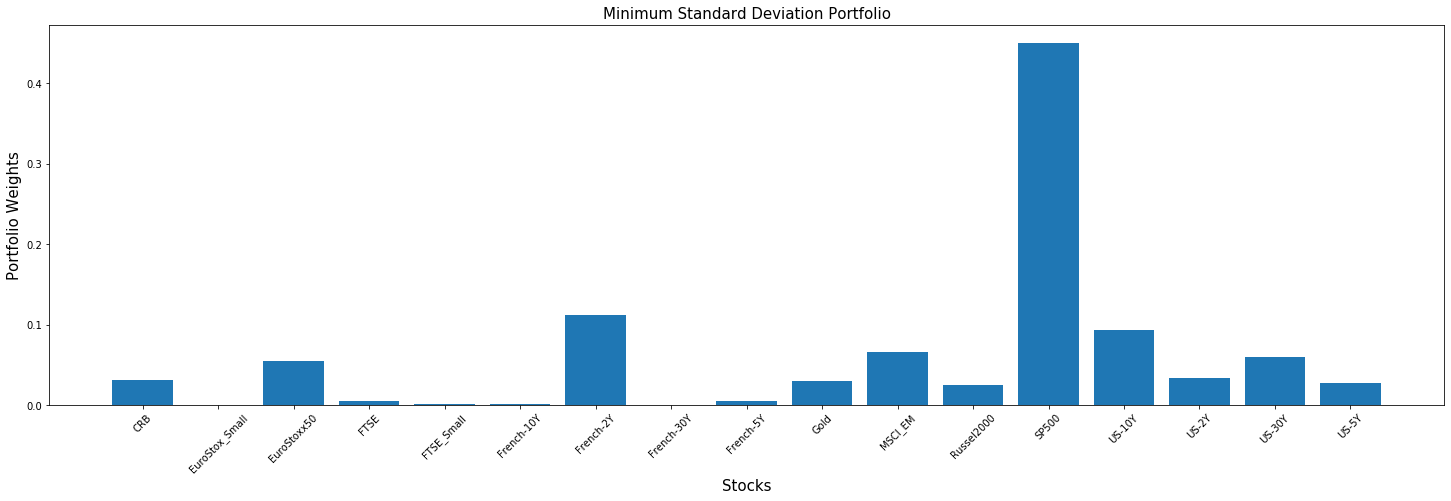

In [103]:
# Plotting our Minimum Standard Deviation portfolio
MSD_weights = hcaaMSD.weights[sorted(hcaaMSD.weights)]
MSD_weights = MSD_weights.values.tolist()
MSD_weights = [item for sublist in MSD_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, MSD_weights)
plt.xticks(y_pos, sorted(hcaaMSD.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Minimum Standard Deviation Portfolio', size=15)
plt.show()

## Sharpe Ratio Portfolio
The Sharpe ratio of the clusters is now used as a risk metric when constructing the optimal portfolio.

In [104]:
# HCAA implementation with sharpe_ratio solution
hcaaSR = HierarchicalClusteringAssetAllocation()
hcaaSR.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                allocation_metric='sharpe_ratio')

print("Sharpe Ratio Portfolio Weights \n", hcaaSR.weights)

Sharpe Ratio Portfolio Weights 
    MSCI_EM       CRB  EuroStoxx50  EuroStox_Small     SP500  Russel2000  \
0   0.0602  0.028999     0.049818        0.000203  0.502472    0.036798   

       FTSE  FTSE_Small  French-2Y  French-5Y  French-10Y  French-30Y  \
0  0.007221    0.001708   0.085296   0.004038     0.00117    0.000275   

       Gold     US-2Y    US-30Y     US-5Y    US-10Y  
0  0.027033  0.030318  0.054678  0.024636  0.085137  


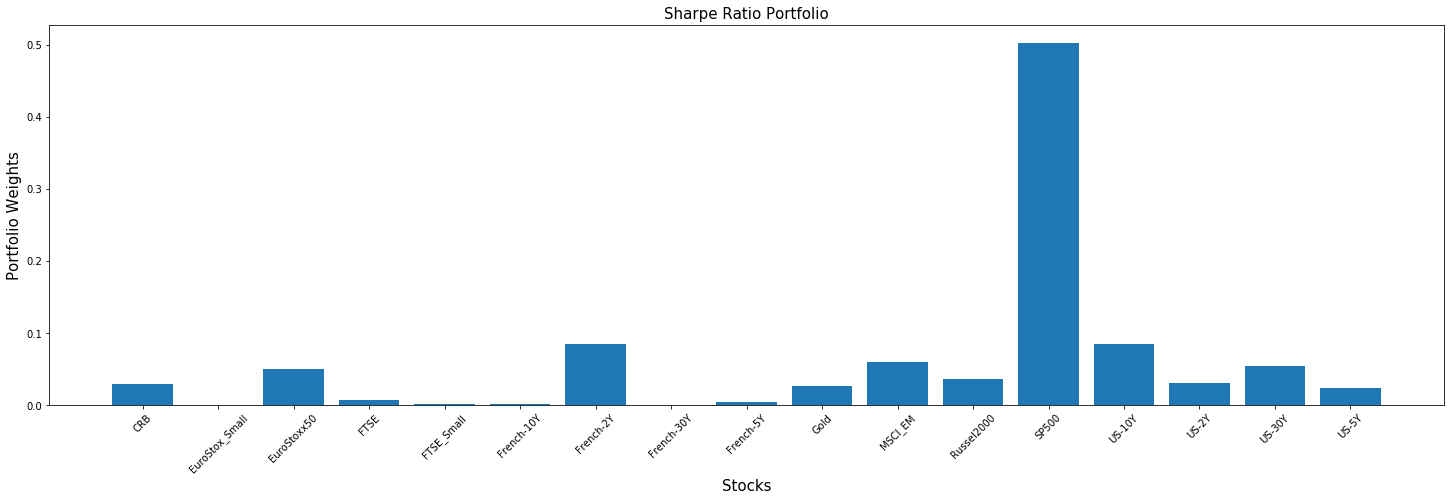

In [105]:
# Plotting our Sharpe ratio portfolio
SR_weights = hcaaSR.weights[sorted(hcaaSR.weights)]
SR_weights = SR_weights.values.tolist()
SR_weights = [item for sublist in SR_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, SR_weights)
plt.xticks(y_pos, sorted(hcaaSR.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Sharpe Ratio Portfolio', size=15)
plt.show()

## Minimum Variance Portfolio
The Minimum Variance portfolio uses the variance of the clusters as a risk metric to calculate asset weights. 

In [106]:
# HCAA implementation with equal_weighting solution
hcaaMV = HierarchicalClusteringAssetAllocation()
hcaaMV.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                allocation_metric='minimum_variance')

print("Minimum Variance Portfolio Weights \n", hcaaEW.weights)

Minimum Variance Portfolio Weights 
        Gold       CRB     SP500  Russel2000      FTSE  EuroStoxx50  \
0  0.021999  0.011912  0.080403       0.125  0.113293     0.011707   

   EuroStox_Small  FTSE_Small   MSCI_EM     US-2Y    US-30Y     US-5Y  \
0         0.10453     0.02047  0.233675  0.012477  0.003181  0.000667   

     US-10Y  French-10Y  French-30Y  French-2Y  French-5Y  
0  0.044597    0.015624    0.055057   0.020408      0.125  


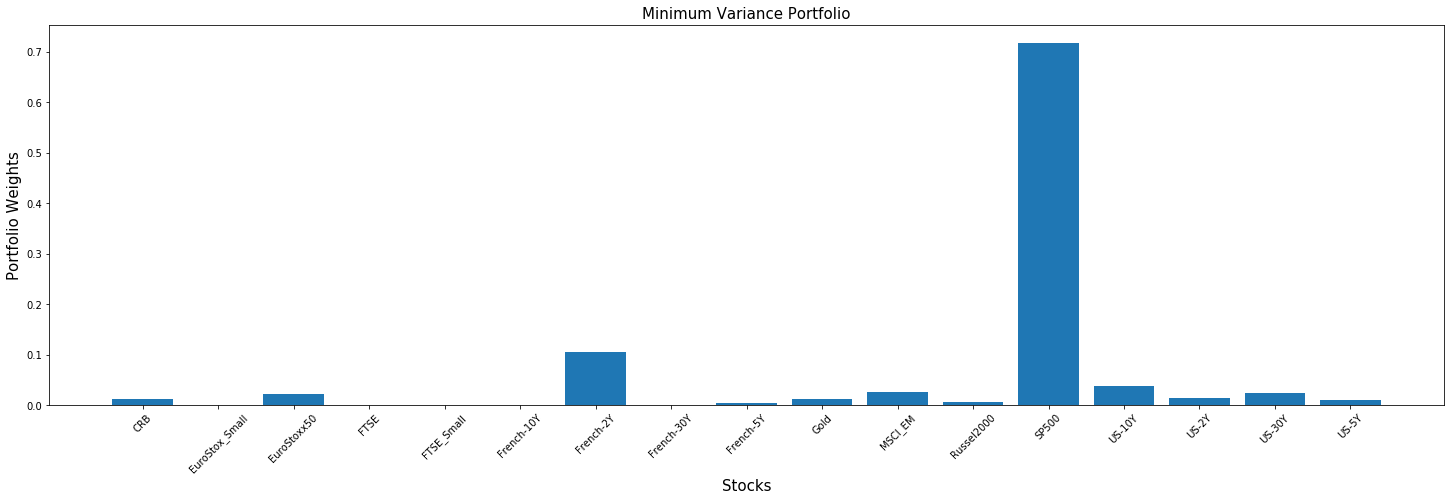

In [107]:
# Plotting our Equal Weighting portfolio
MV_weights = hcaaMV.weights[sorted(hcaaMV.weights)]
MV_weights = MV_weights.values.tolist()
MV_weights = [item for sublist in MV_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, MV_weights)
plt.xticks(y_pos, sorted(hcaaMV.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Minimum Variance Portfolio', size=15)
plt.show()

## Expected Shortfall Portfolio
The Expected Shortfall (CVaR) of the clusters is now being used as a risk metric to contruct our optimal portfolio.

In [108]:
# HCAA implementation with expected_shortfall solution
hcaaES = HierarchicalClusteringAssetAllocation()
hcaaES.allocate(asset_names=stock_prices.columns,
                asset_prices=stock_prices,
                allocation_metric='expected_shortfall')

print("Expected Shortfall Portfolio Weights \n", hcaaES.weights)

Expected Shortfall Portfolio Weights 
     MSCI_EM       CRB  EuroStoxx50  EuroStox_Small     SP500  Russel2000  \
0  0.070775  0.034094     0.058569        0.000346  0.374067    0.037904   

       FTSE  FTSE_Small  French-2Y  French-5Y  French-10Y  French-30Y  \
0  0.007438     0.00176   0.144966   0.006862    0.001988    0.000467   

       Gold     US-2Y    US-30Y     US-5Y    US-10Y  
0  0.031782  0.035644  0.064283  0.028964  0.100093  


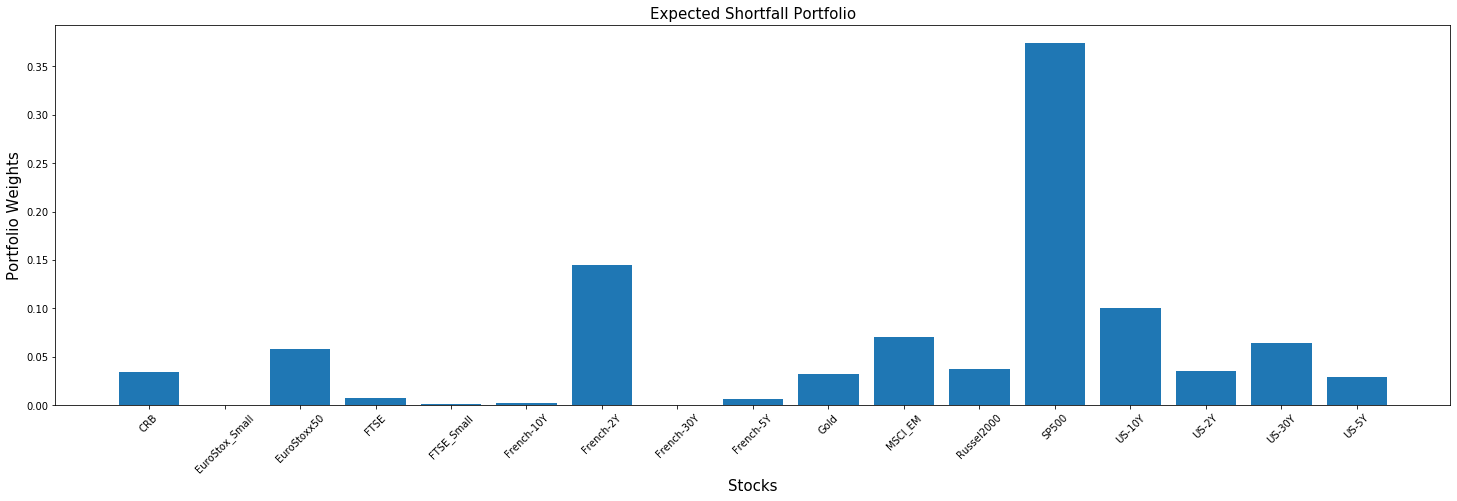

In [109]:
# Plotting our Expected Shortfall portfolio
ES_weights = hcaaES.weights[sorted(hcaaES.weights)]
ES_weights = ES_weights.values.tolist()
ES_weights = [item for sublist in ES_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, ES_weights)
plt.xticks(y_pos, sorted(hcaaES.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Expected Shortfall Portfolio', size=15)
plt.show()

## Conditional Drawdown at Risk Portfolio
The Conditional Drawdown at Risk (CDaR) of the clusters is used as a risk metric.

In [110]:
# HCAA implementation with conditional_drawdown_at_risk solution
hcaaCDR = HierarchicalClusteringAssetAllocation()
hcaaCDR.allocate(asset_names=stock_prices.columns,
                 asset_prices=stock_prices,
                 allocation_metric='conditional_drawdown_risk')

print("Conditional Drawdown at Risk Portfolio Weights \n", hcaaCDR.weights)

Conditional Drawdown at Risk Portfolio Weights 
     MSCI_EM       CRB  EuroStoxx50  EuroStox_Small     SP500  Russel2000  \
0  0.068051  0.032781     0.056315        0.000258  0.446438    0.024481   

       FTSE  FTSE_Small  French-2Y  French-5Y  French-10Y  French-30Y  \
0  0.004804    0.001137   0.108063   0.005115    0.001482    0.000348   

       Gold     US-2Y    US-30Y     US-5Y   US-10Y  
0  0.030559  0.034272  0.061809  0.027849  0.09624  


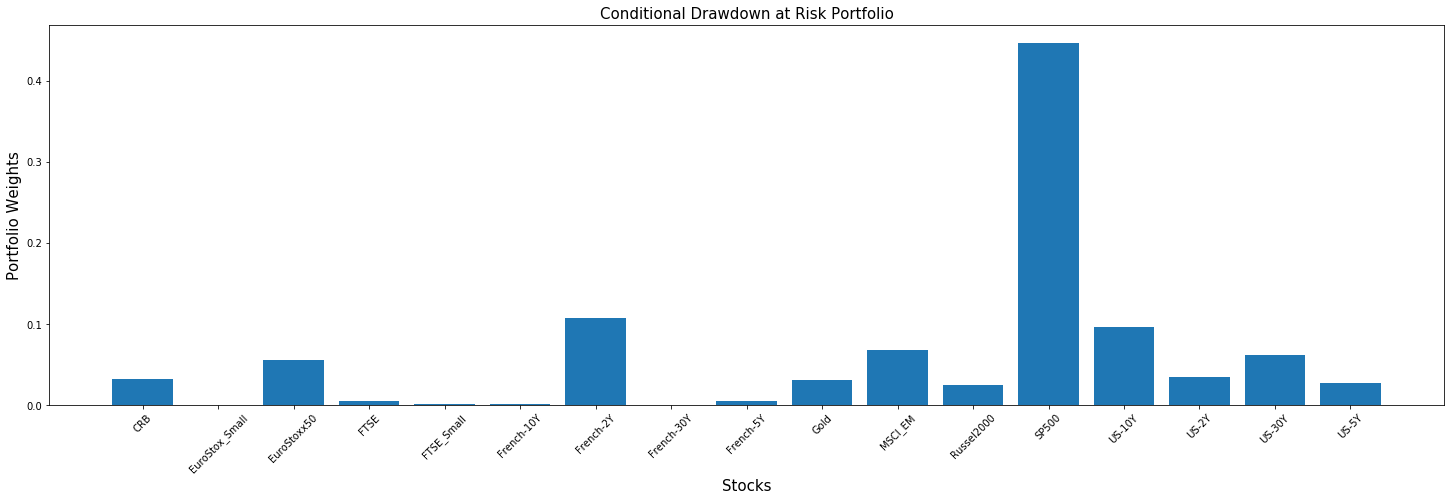

In [111]:
# Plotting our Conditional Drawdown at Risk portfolio
CDR_weights = hcaaCDR.weights[sorted(hcaaCDR.weights)]
CDR_weights = CDR_weights.values.tolist()
CDR_weights = [item for sublist in CDR_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, CDR_weights)
plt.xticks(y_pos, sorted(hcaaCDR.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Conditional Drawdown at Risk Portfolio', size=15)
plt.show()

## Comparison of Allocation Metrics
In the following graph, we can see how the portfolio weightings differ for each solution.

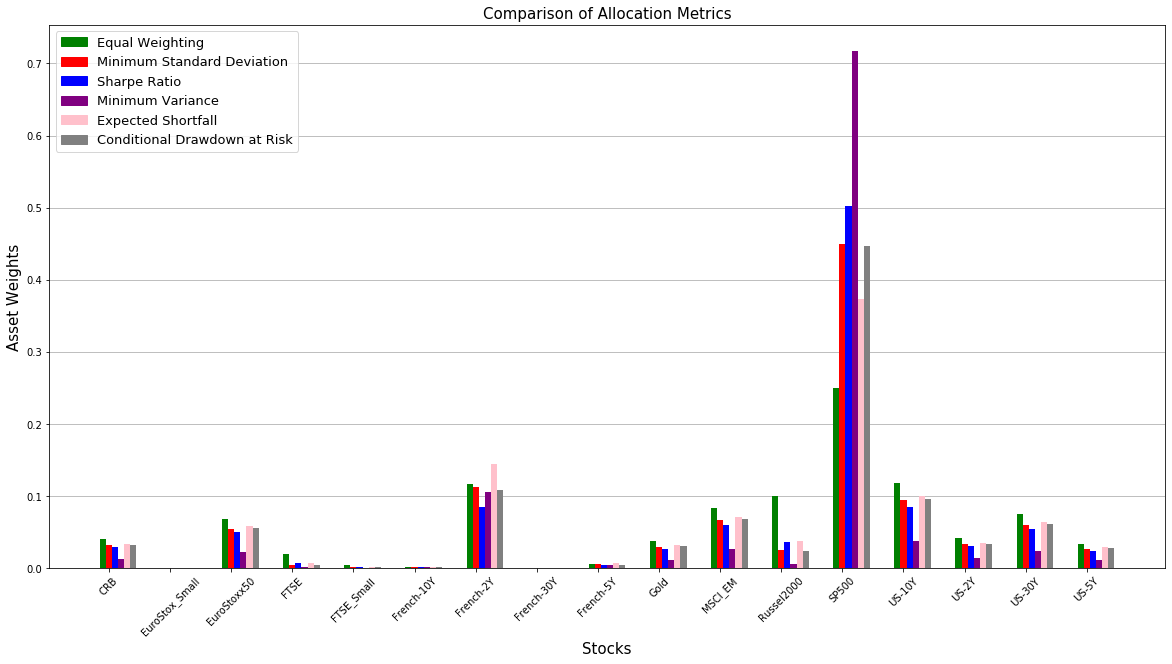

In [124]:
x = np.arange(len(ward))
bar_width = 0.1

plt.figure(figsize=(20,10))
plt.bar(x, ward, color='green', width=bar_width, zorder=2)
plt.bar(x + bar_width, MSD_weights, color='red', width=bar_width, zorder=2)
plt.bar(x + bar_width*2, SR_weights, color='blue', width=bar_width, zorder=2)
plt.bar(x + bar_width*3, MV_weights, color='purple', width=bar_width, zorder=2)
plt.bar(x + bar_width*4, ES_weights, color='pink', width=bar_width, zorder=2)
plt.bar(x + bar_width*5, CDR_weights, color='grey', width=bar_width, zorder=2)

plt.xticks(x + bar_width, sorted(hcaaMV_average.weights), rotation=45, size=10)
plt.title('Comparison of Allocation Metrics', size=15)
plt.xlabel('Stocks', size=15)
plt.ylabel('Asset Weights', size=15)

green_patch = mpatches.Patch(color='green', label='Equal Weighting')
red_patch = mpatches.Patch(color='red', label='Minimum Standard Deviation')
blue_patch = mpatches.Patch(color='blue', label='Sharpe Ratio')
purple_patch=mpatches.Patch(color='purple', label='Minimum Variance')
pink_patch = mpatches.Patch(color='pink', label='Expected Shortfall')
grey_patch=mpatches.Patch(color='grey', label='Conditional Drawdown at Risk')
plt.legend(handles=[green_patch, red_patch, blue_patch, purple_patch, pink_patch, grey_patch], loc='upper left', prop={'size': 13})

plt.grid(axis='y')

plt.show()

## Custom Input from Users
MlFinLab also provides users with a lot of customizability when it comes to creating their optimal portfolios. Instead of providing the raw historical closing prices for the assets, users can input the asset returns, a covariance matrix of asset returns, and expected asset returns to calculate their optimal portfolio. If you would like to learn more about the customizbility within MlFinLab's HCAA implementation, please refer to the __[official documentation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__.

The following parameters in the allocate() method are utilized in order to construct a custom use case:
1. 'asset_returns': (pd.DataFrame/NumPy matrix) A matrix of asset returns
2. 'covariance_matrix': (pd.DataFrame/NumPy matrix) A covariance matrix of asset returns
3. 'expected_asset_returns: (list) A list of mean asset returns

In this example of using custom input, we will be constructing two optimal portfolios. The first portfolio will be constructed under the Conditional Drawdown at Risk solution and the second will be constructed under the Sharpe Ratio solution

**Please note that you only need to use asset_returns and covariance_matrix for the Conditional Drawdown at Risk solution.**

To make some of the necessary calculations, we will make use of the ReturnsEstimation class provided by MlFinLab.

In [113]:
# Importing ReturnsEstimation class from MlFinLab
from mlfinlab.portfolio_optimization.returns_estimators import ReturnsEstimation

In [114]:
# Calculating our asset returns
returns = ReturnsEstimation.calculate_returns(stock_prices)
returns.head()

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
Dates,,,,,,,,,,,,,,,,,
2018-12-06,0.006859,0.008733,-0.004088,0.041385,0.002435,-0.006818,-0.023994,-0.047660,0.001174,-0.003270,-0.010433,-0.029565,-0.004721,0.017401,0.022500,0.065782,0.036482
2018-12-04,-0.057825,-0.009095,-0.044086,0.030448,0.005769,0.001784,0.008140,0.032301,0.003379,0.009410,0.015242,0.020924,-0.074285,0.005010,-0.049065,0.031770,-0.025176
2018-12-03,-0.006004,-0.004209,0.044681,-0.014681,0.003882,-0.002711,-0.010076,-0.024782,0.001891,0.001978,-0.002816,-0.016668,0.028080,0.012402,0.015076,0.038507,0.011597
2018-12-02,-0.005225,-0.017853,-0.045641,0.004474,0.002384,-0.001481,-0.008961,-0.008209,0.003377,0.003962,0.002495,0.002640,-0.068754,-0.024053,-0.023033,-0.056314,-0.014560
2018-12-01,0.083820,0.072548,0.049036,0.004741,0.003255,0.005818,0.013274,-0.009223,0.000944,0.009164,0.027443,0.059279,0.067734,0.053270,0.060397,0.047509,0.001229


In [115]:
# Calculating our covariance matrix
cov = returns.cov()
cov

,FTSE,EuroStoxx50,SP500,Gold,French-2Y,French-5Y,French-10Y,French-30Y,US-2Y,US-5Y,US-10Y,US-30Y,Russel2000,EuroStox_Small,FTSE_Small,MSCI_EM,CRB
FTSE,0.000945,0.000964,0.000738,0.000014,-0.000041,-0.000034,-0.000005,0.000058,-0.000011,-0.000062,-0.000144,-0.000315,0.001016,0.000889,0.000698,0.000988,0.000295
EuroStoxx50,0.000964,0.001961,0.000944,-0.000534,-0.000050,-0.000068,-0.000070,-0.000112,-0.000033,-0.000184,-0.000373,-0.000753,0.001193,0.001705,0.000933,0.001170,0.000196
SP500,0.000738,0.000944,0.001141,-0.000124,-0.000085,-0.000007,0.000092,0.000142,-0.000015,-0.000077,-0.000168,-0.000350,0.001370,0.000938,0.000802,0.000946,0.000253
Gold,0.000014,-0.000534,-0.000124,0.002088,-0.000005,0.000090,0.000192,0.000426,0.000048,0.000279,0.000497,0.000778,-0.000141,-0.000229,-0.000129,0.000719,0.000422
French-2Y,-0.000041,-0.000050,-0.000085,-0.000005,0.000021,0.000005,-0.000016,-0.000028,0.000001,0.000002,0.000004,0.000010,-0.000102,-0.000058,-0.000069,-0.000065,-0.000022
French-5Y,-0.000034,-0.000068,-0.000007,0.000090,0.000005,0.000072,0.000143,0.000250,0.000008,0.000050,0.000108,0.000214,-0.000062,-0.000078,-0.000018,-0.000028,-0.000021
French-10Y,-0.000005,-0.000070,0.000092,0.000192,-0.000016,0.000143,0.000366,0.000694,0.000015,0.000101,0.000240,0.000513,-0.000039,-0.000094,0.000022,0.000055,-0.000032
French-30Y,0.000058,-0.000112,0.000142,0.000426,-0.000028,0.000250,0.000694,0.001546,0.000030,0.000194,0.000464,0.001026,-0.000075,-0.000175,-0.000024,0.000227,0.000001
US-2Y,-0.000011,-0.000033,-0.000015,0.000048,0.000001,0.000008,0.000015,0.000030,0.000005,0.000020,0.000031,0.000046,-0.000022,-0.000026,-0.000011,-0.000004,0.000005
US-5Y,-0.000062,-0.000184,-0.000077,0.000279,0.000002,0.000050,0.000101,0.000194,0.000020,0.000105,0.000183,0.000302,-0.000132,-0.000152,-0.000077,-0.000019,0.000005


In [116]:
# Calculating our mean asset returns
mean_returns = ReturnsEstimation.calculate_mean_historical_returns(stock_prices)
mean_returns

FTSE              0.074053
EuroStoxx50       0.219201
SP500             0.032265
Gold              0.245129
French-2Y         0.023967
French-5Y        -0.000393
French-10Y        0.004391
French-30Y        0.128036
US-2Y             0.000946
US-5Y             0.007074
US-10Y            0.033125
US-30Y            0.167052
Russel2000        0.137272
EuroStox_Small    0.184402
FTSE_Small        0.044272
MSCI_EM           0.268466
CRB               0.076896
dtype: float64

### Conditional Drawdown at Risk Solution

In [117]:
# From here, we can now create our portfolio
hcaaCDR_custom = HierarchicalClusteringAssetAllocation()
hcaaCDR_custom.allocate(asset_names=stock_prices.columns,
                        asset_returns=returns,
                        covariance_matrix=cov, 
                        allocation_metric='conditional_drawdown_risk')

print("Custom HCAA Portfolio - Conditional Drawdown at Risk \n", hcaaCDR_custom.weights)

Custom HCAA Portfolio - Conditional Drawdown at Risk 
     MSCI_EM       CRB  EuroStoxx50  EuroStox_Small     SP500  Russel2000  \
0  0.037252  0.017945     0.030827        0.000947  0.318776    0.027539   

       FTSE  FTSE_Small  French-2Y  French-5Y  French-10Y  French-30Y  \
0  0.005404    0.001278    0.39725   0.018805    0.005447    0.001279   

       Gold     US-2Y    US-30Y     US-5Y    US-10Y  
0  0.016728  0.018761  0.033835  0.015245  0.052683  


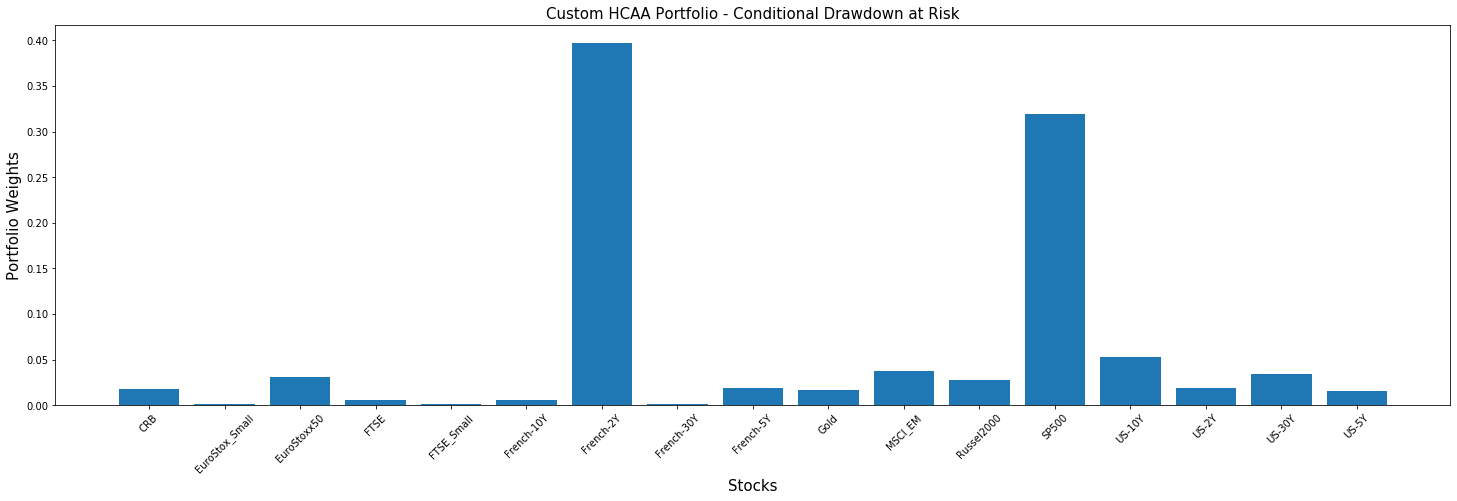

In [118]:
# Plotting our custom portfolio
custom_weights = hcaaCDR_custom.weights[sorted(hcaaCDR_custom.weights)]
custom_weights = custom_weights.values.tolist()
custom_weights = [item for sublist in custom_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, custom_weights)
plt.xticks(y_pos, sorted(hcaa_custom.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Custom HCAA Portfolio - Conditional Drawdown at Risk', size=15)
plt.show()

### Sharpe Ratio Solution

In [119]:
# creating our custom Sharpe Ratio solution
hcaaSR_custom = HierarchicalClusteringAssetAllocation()
hcaaSR_custom.allocate(asset_names=stock_prices.columns,
                       asset_returns=returns,
                       covariance_matrix=cov, 
                       expected_asset_returns=mean_returns,
                       allocation_metric='sharpe_ratio')

print("Custom HCAA Portfolio - Sharpe Ratio \n", hcaaSR_custom.weights)

Custom HCAA Portfolio - Sharpe Ratio 
    MSCI_EM       CRB  EuroStoxx50  EuroStox_Small     SP500  Russel2000  \
0   0.0602  0.028999     0.049818        0.000203  0.502472    0.036798   

       FTSE  FTSE_Small  French-2Y  French-5Y  French-10Y  French-30Y  \
0  0.007221    0.001708   0.085296   0.004038     0.00117    0.000275   

       Gold     US-2Y    US-30Y     US-5Y    US-10Y  
0  0.027033  0.030318  0.054678  0.024636  0.085137  


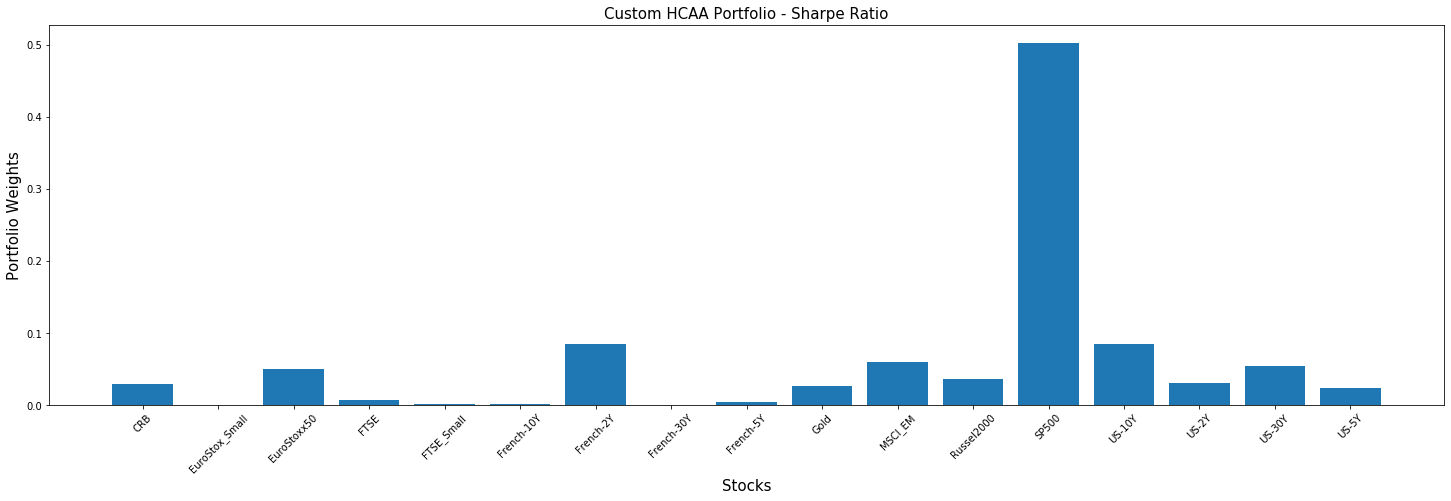

In [120]:
# plotting our custom Sharpe Ratio portfolio
custom_weights = hcaaSR_custom.weights[sorted(hcaaSR_custom.weights)]
custom_weights = custom_weights.values.tolist()
custom_weights = [item for sublist in custom_weights for item in sublist]
y_pos = np.arange(len(stock_prices.columns))

plt.figure(figsize=(25,7))
plt.bar(y_pos, custom_weights)
plt.xticks(y_pos, sorted(hcaa_custom.weights), rotation=45, size=10)
plt.xlabel('Stocks', size=15)
plt.ylabel('Portfolio Weights', size=15)
plt.title('Custom HCAA Portfolio - Sharpe Ratio', size=15)
plt.show()

Through this implementation, we can see alternative ways of which users can construct an optimal portfolio using the HCAA techniques implemented by MlFinLab.

## Conclusion
Throughout this notebook, we saw how we can apply Raffinot's work from his Hierarchical Equal Risk Contribution technique through the MlFinLab library. We worked through how we can specify many different parameters to solve for our optimal portfolio, including chaning our risk metrics and the type of linkage algorithms being used for clustering. Users were also made aware of how they can customize their input to have more control over their calculations. If you would like to learn more about the HERC technique, please refer to Raffinot's original HERC paper linked at the top of this notebook. Additionally, please refer to the official documentation for this tutorial which can be found __[at this link](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__ if you have any further questions.

## Sources
Official MlFinLab Documentation:
- __[Hierarchical Clustering Asset Allocation](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/hierarchical_clustering_asset_allocation.html)__
- __[Estimation of Returns](https://mlfinlab.readthedocs.io/en/latest/portfolio_optimisation/returns_estimation.html)__

Algorithms:
- __[Hierarchical Risk Parity - Hudson & Thames](https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/)__
- __[Hierarchical Equal Risk Contribution - Thomas Raffinot](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3237540)__
- __[Hierarchical Clustering Based Asset Allocation - Thomas Raffinot](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2840729)__